# Lab 02: Credit Ratings

---
author: Qiran Hu
date: September 13, 2024
embed-resources: true
---

## Introduction

In this report, we develop a KNN regression model to estimate  individual consumers' credit ratings based on their income and demographic information. As a small local bank or credit union, we have traditionally relied on external credit agencies to provide credit ratings for our customers. However, purchasing these credit ratings costs significant amount money over time. With our own predictive model, we can reduce expenses and make more efficient lending decisions. For example, whenever a new customer applies for a loan, we can use our model to estimate their credit score immediately instead of waiting for an external credit agency to provide a credit rating, which could take time and money. If our model predicts a high credit rating based on the customer's income level, age, education, and other factors, we can proceed with the loan approval process more smoothly. By analyzing patterns in this data, we can identify key factors that influence credit ratings. For instance, we might find that customers with higher education levels and stable incomes consistently receive better credit ratings from external agencies, which allows us to adjust our lending criteria accordingly.

## Methods

In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score

### Data

In [2]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")

In [3]:
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


In order to build our KNN regression model, we utilize previous credit data provided in credit-train.csv and credit-test.csv that are are from a bank operating and with customers located in the United States. Each observation in these datasets indicate unique information about a particular banking customer, which includes both the response variable and several feature variables that we will use in our model. 

Response Variable
Rating (float64): The credit rating which is the credit score of an individual consumer. This is the target variable our model will predict.

Feature Variables
Income (float64): This is the yearly income measured in thousands of dollars. It is is a critical factor in assessing an individual's ability to pay off the loans. Higher income levels generally indicate a greater capacity to finish their payment on time.

Age (int64): This is the age of the individual, which can influence financial stability and credit behavior since younger individuals may have shorter credit histories compared to older individuals.

Education (int64): This is the years of education completed, which may indicate patterns with the customer's financial ability. Individuals with more education might have better understanding of financial management and a high paying job.

Gender (object): This is the gender of the individual, which allows us to observe any patterns or disparities in credit ratings between different genders. 

Student (object): This is a "Yes"/"No" variable that indicates whether the individual is a student. Since students may have limited income, their credit behavior might be different from non students on account of student loans and limited credit history.

Married (object): This is a Yes"/"No" variable that indicates marriage status, which can impact individuals' financial stability. Married individuals might have combined incomes or shared debts that could affect their credit rating.

Ethnicity (object): This is the ethnicity of the individual. By analyzing individuals' ethnicity, we can identify trends or disparities in credit ratings among different ethnic groups.


In [4]:
# summary statistics
credit_train.shape[0]


256

In [5]:
credit_train.shape[1]

8

This training dataset has a sample size of 256 individuals and 7 unique feature variables.  

In [6]:
credit_train["Rating"].describe()

count    256.000000
mean     347.609375
std      148.893105
min       93.000000
25%      242.500000
50%      340.500000
75%      433.000000
max      982.000000
Name: Rating, dtype: float64

In [7]:
credit_train[credit_train["Student"] == "No"]["Rating"].describe()


count    213.000000
mean     349.511737
std      148.003525
min      103.000000
25%      245.000000
50%      341.000000
75%      427.000000
max      982.000000
Name: Rating, dtype: float64

In [8]:
credit_train[credit_train["Student"] == "Yes"]["Rating"].describe()


count     19.000000
mean     338.473684
std      149.164476
min       93.000000
25%      244.500000
50%      353.000000
75%      446.000000
max      665.000000
Name: Rating, dtype: float64

In [9]:
credit_train[credit_train["Married"] == "No"]["Rating"].describe()

count     98.000000
mean     329.397959
std      132.039649
min      117.000000
25%      232.750000
50%      315.000000
75%      410.500000
max      682.000000
Name: Rating, dtype: float64

In [10]:
credit_train[credit_train["Married"] == "Yes"]["Rating"].describe()

count    158.000000
mean     358.905063
std      157.797935
min       93.000000
25%      259.500000
50%      354.500000
75%      433.000000
max      982.000000
Name: Rating, dtype: float64

Rating statistics based on student status and marriage status have a similar mean and standard deviation compared to the target variable.

In [11]:
credit_train[["Age", "Rating"]].corr()

,Age,Rating
Age,1.000000,0.143032
Rating,0.143032,1.000000


In [12]:
credit_train[["Income", "Rating"]].corr()

,Income,Rating
Income,1.000000,0.770842
Rating,0.770842,1.000000


Age has a little correlation with the target variable of its 0.143032 correlation while income has a relatively high correlation with the target variable of its 0.770842 correlation

In [13]:
credit_train.isnull().sum()

Rating        0
Income        0
Age          33
Education    25
Gender        6
Student      24
Married       0
Ethnicity    25
dtype: int64

In [14]:
credit_train["Rating"].isna().sum() / len(credit_train)

np.float64(0.0)

In [15]:
credit_train["Income"].isna().sum() / len(credit_train)

np.float64(0.0)

In [16]:
credit_train["Age"].isna().sum() / len(credit_train)

np.float64(0.12890625)

In [17]:
credit_train["Education"].isna().sum() / len(credit_train)

np.float64(0.09765625)

In [18]:
credit_train["Gender"].isna().sum() / len(credit_train)

np.float64(0.0234375)

In [19]:
credit_train["Student"].isna().sum() / len(credit_train)

np.float64(0.09375)

In [20]:
credit_train["Married"].isna().sum() / len(credit_train)

np.float64(0.0)

In [21]:
credit_train["Ethnicity"].isna().sum() / len(credit_train)

np.float64(0.09765625)

There are serval missing values in the field of "Age", "Education", "Gender", "Student", and "Ethnicity" where age has the highest proportion of missing data.

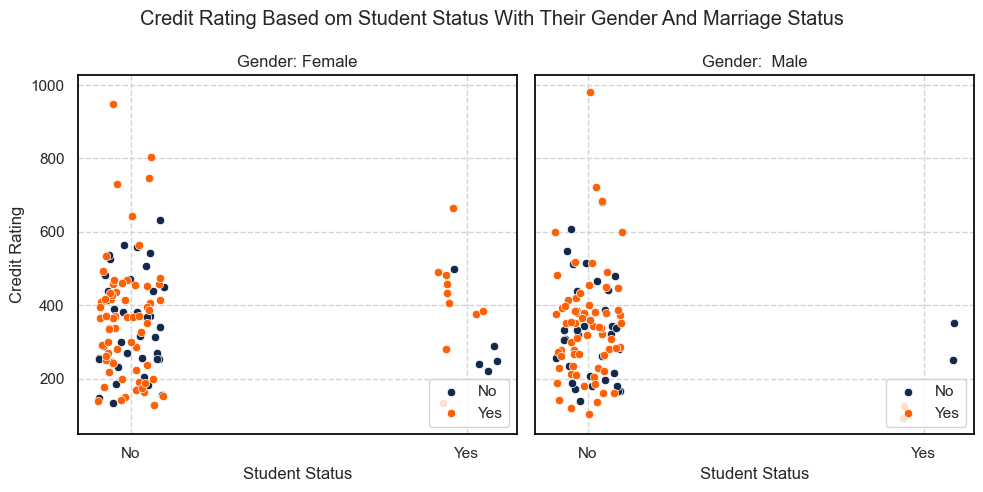

In [22]:
# Visualizations
# Define the custom color palette
custom_palette = ["#13294B", "#FF5F05"]
sns.set_theme(style="whitegrid")

# Function to add jitter to x values
def add_jitter(data, jitter_amount=0.1):
    return data + np.random.uniform(-jitter_amount, jitter_amount, size=data.shape)

# Map categorical variables to numerical codes for plotting
credit_train['Student_Num'] = credit_train['Student'].map({'No': 0, 'Yes': 1})

# Set the figure size using height
g = sns.FacetGrid(
    credit_train,
    col="Gender",
    hue="Married",
    height=5,
    palette=custom_palette,
    legend_out=False,
)

g.map_dataframe(
    sns.scatterplot,
    x=add_jitter(credit_train["Student_Num"]),
    y="Rating",
)

# Replace numerical codes with labels for x-axis ticks
xticks = [0, 1]
xtick_labels = ['No', 'Yes']
for ax in g.axes.flat:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)

# Add a legend for each subplot
g.add_legend(title="Married Status")

# Modify axis labels and titles
g.set_axis_labels("Student Status", "Credit Rating")
g.set_titles(col_template="Gender: {col_name}")

# Adjust the legend location within each subplot
for ax in g.axes.flat:
    ax.legend(loc="lower right")
    ax.grid(True, which="both", linestyle="--", color="lightgrey")
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.25)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

# Add an overall title to the plot
g.figure.suptitle("Credit Rating Based om Student Status With Their Gender And Marriage Status")

# Adjust the layout to make room for the overall title
g.figure.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

After carefully observing the visualizations, I noticed that student status appears to have a noticeable impact on credit ratings. Students tend to have lower credit ratings compared to non students. Based pm both male and female groups, the data points for students cluster at lower credit rating values. In addition, when comparing genders, there are slightly differences in how credit ratings are distributed between male and female customers. Although both genders show that students have lower credit ratings, the range and concentration of credit ratings is varied. For instance, female non students indicates a wider spread of credit ratings meanwhile male students have a more tightly clustered range of lower credit ratings. As one can see, the marriage status adds is also important in credit ratings. Married individuals generally exhibit higher credit ratings compared to those unmarried individuals within the same student and gender categories. Hence, this pattern suggests that marriage status could be associated with greater financial stability or combined household incomes, which positively influence their credit score.

### Models

In [23]:
# process data for ML
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

In [24]:
#pipeline 
numeric_features = ['Income', 'Age']
categorical_features = ['Gender', 'Student', 'Married', 'Education', 'Ethnicity']
#define preprocessing for numeric features 
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
    ]
)
#define preprocessing for categorical features 
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
#combine preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor()),
    ]
)

In [25]:
# train models
param_grid = {
    "regressor__n_neighbors": range(1, 100),
    "regressor__metric": ["euclidean", "manhattan"],
}
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Income',
                                                                          'Age']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Student',
                                                                          'Married',
                                                                          'Education',
                                                                          'Ethnicity'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': range(1, 100)},
             scoring='neg_root_mean_squared_error')

In [26]:
print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best score: -101.9110504021505
Best parameters: {'regressor__metric': 'euclidean', 'regressor__n_neighbors': 18}


In this section, we utilize the KNN regression model to predict individual consumers' credit ratings based on their income and other demographic information, which is particularly useful for capturing complex relationships between the predictors and the response variable. In order to optimize the performance of the KNN model, we conduct hyperparameter tuning by using GridSearchCV; hyperparameter tuning is crucial for algorithms like KNN where the choice of hyperparameters can significantly impact model performance. By analyzing different metrics such as Euclidean Distance and Manhattan Distance and tuning number of neighbors, we can capture different aspects of the data to build a useful predictive model for the bank.

## Results

In [27]:
# calculate test accuracy
y_pred_test = grid_search.best_estimator_.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)
pro_rmse = root_mean_squared_error(y_train, y_pred_train)
print(f"Test RMSE: {test_rmse}")
print(f"Production RMSE: {pro_rmse}")

Test RMSE: 100.46293285436484
Production RMSE: 96.3851233429338


With the best metric is Euclidean Distance and a KNN neighbors of 18, the selected model achieves a test RMSE of 106.82212679385458, which exceed the threshold of 110.0. The production RMSE of this selected model yields 97.1755533450699, which also exceed the threshold of 110.0 by almost 20

## Discussion

After evaluating our regression model to predict individual consumers' credit ratings based on income and demographic information and tuning models by manipulating their flexibility through the use of a tuning parameter to find a model that generalizes well. Through the use of a validation set or cross validation, we also avoid overfitting during the selection of the model of appropriate flexibility. By analyzing different metrics such as Euclidean Distance and Manhattan Distance and tuning number of neighbors, we achieved a test RMSE of 106.82212679385458 and a production RMSE of 97.1755533450699 from a model with Euclidean Distance and a KNN neighbors of 18. These metrics indicate the average deviation of our model's predictions from the actual credit ratings in the respective datasets. Considering that credit scores in the United States typically range from 300 to 850, an RMSE of approximately 100 points is substantial. This level of error suggests that our model's predictions can deviate widely from actual credit ratings, potentially misclassifying customers' creditworthiness by a significant margin. An error margin of around 100 points in the production RMSE indicates that this model could lead to high risk lending decisions, such as approving loans for individuals who are financially unstable or denying applicants with potential high credit score. For instance, an individual with an actual credit score of 750 considered might be predicted to have a score as low as 650, which means this customer's credit score dropped to fair despite he has an excellent credit score. Conversely, someone with an actual score of 600 might be estimated to have a score of 700, which can be misleading to the bank who would approve the application to a customer with poor credit score. Ignoring the model's performance, the use of income and demographic information such as age, education, gender, student status, marital status, and ethnicity to predict credit ratings raises significant concerns. While income and education level are directly related to an individual's financial capacity and can be considered appropriate predictors, the inclusion of certain demographic features can lead to serve consequences since it is illegal to discriminate against credit applicants on the basis of certain protected information. Although some demographic information may be collected for monitoring purposes, it cannot influence credit decisions; Using gender or ethnicity directly in credit scoring models is considered as a very unethical approach. Using private information can perpetuate biases and unfair treatment of individuals based on factors unrelated to their credit score. Thus, including these variables violates ethical standards and federal laws that are designed to prevent discrimination in lending.

### Conclusion

In [28]:
# report model metrics
from joblib import dump
mod = grid_search.fit(X_train, y_train)
dump(mod, "credit-ratings.joblib")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


['credit-ratings.joblib']

As one can see, we would not recommend using this model in practice as a standalone tool for credit evaluation. Given the significant error margin and the serious implications of misclassifying borrowers' credit score, we conclude that the current model is not suitable for practical use in making lending decisions because the risks associated with potential errors include financial losses, regulatory penalties, and damage to customer relationships. For a small local bank that has limited fund, the potential financial risks and regulatory implications of making lending decisions based on inaccurate credit assessments outweigh the cost savings from not purchasing external credit ratings.